
## Markov Decision process (MDP) implementation yo

Imagine an agent navigating a 2D, discrete environment (a grid). The cells of the grid, depicted below, correspond to the states of the environment. At each cell, 4 actions are possible: `north`, `south`, `east` and `west`. These actions move the agent in the corresponding direction. There are 2 special states `A` and `B`, from which any action always pushes the agent to states `A'` and `B'`, respectively. This special transition also results in larger rewards (+10 and +5, respectively). Actions that would take the agent off the grid have no effect (the agent remains in the same position) and result in a reward of -1. Other actions result in 0 reward.
<img alt="Grid world MDP" height="300" src="https://drive.google.com/uc?id=1Wx6ALilXFkkRG5scC4r8h0U--qffgt9s" title="Grid World" width="500"/>

**References:**
- Sutton & Barto, Ch.3, p.60 (example 3.5)

In [8]:
grid_size = 5
A_pos = [0, 1]
A_prime_pos = [4, 1]
B_pos = [0, 3]
B_prime_pos = [2, 3]
discount = 0.9

# left, up, right, down
ACTIONS = [np.array([0, -1]),
           np.array([-1, 0]),
           np.array([0, 1]),
           np.array([1, 0])]
ACTIONS_REP = [ '←', '↑', '→', '↓']

**a**) Define the Grid World's MDP dynamics: $p(s',r|s,a)$

**b**) Suppose the agent selects all four actions with equal probability in all states, i.e. the agent assumes a random uniform policy. Represent the state-value function $v(s)$ associated with this policy, assuming a discounting factor $\gamma = 0.9$.

**Note:** This and the following exercises depict methods to compute state-value functions by value iteration and the direct solution of the linear Bellman equations. Value iteration methods will be covered in detail next week, but the exercise is used here to demonstrate the application of the Bellman equations in a concrete case.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.table import Table

class GridWorld:
    def __init__(self, grid_size, posA, posA_prime, posB, posB_prime, actions, action_representations=None):
        self.grid_size = grid_size
        self.A = posA
        self.A_prime = posA_prime
        self.B = posB
        self.B_prime = posB_prime
        self.action_space = actions
        self.action_representations = action_representations

    def step(self, state, action, rw_scale=1.):
        # special states
        if state == self.A:
            return self.A_prime, rw_scale*10
        if state == self.B:
            return self.B_prime, rw_scale*5

        # others
        next_state = (np.array(state) + action).tolist()
        x, y = next_state
        # boundaries
        if x < 0 or x >= self.grid_size or y < 0 or y >= self.grid_size:
            reward = -1.0
            next_state = state
        # all other
        else:
            reward = 0
        return next_state, rw_scale*reward

    def value_function(self, action_probability, discount):
        A = -1 * np.eye(self.grid_size * self.grid_size)
        b = np.zeros(self.grid_size * self.grid_size)
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                s = [i, j]  # current state
                index_s = np.ravel_multi_index(s, (self.grid_size, self.grid_size))
                for a in self.action_space:
                    s_, r = self.step(s, a)
                    index_s_ = np.ravel_multi_index(s_, (self.grid_size, self.grid_size))
                    A[index_s, index_s_] += action_probability * discount
                    b[index_s] -= action_probability * r
        x = np.linalg.solve(A, b)
        return x

    def value_iteration(self, action_probability, discount, rw_scale=1.):
        """
        Calculate the state-value function, using the Bellman equation
        """
        value = np.zeros((self.grid_size, self.grid_size))
        while True:
            # keep iteration until convergence
            new_value = np.zeros_like(value)
            for i in range(self.grid_size):
                for j in range(self.grid_size):
                    for action in self.action_space:
                        (next_i, next_j), reward = self.step([i, j], action, rw_scale)
                        # Bellman expectation equation
                        new_value[i, j] += action_probability * (reward + discount * value[next_i, next_j])
            if np.sum(np.abs(value - new_value)) < 1e-4: # cut-off
                return new_value
            else:
                value = new_value

    def optimal_value_function(self, discount):
        value = np.zeros((self.grid_size, self.grid_size))
        while True:
            # keep iteration until convergence
            new_value = np.zeros_like(value)
            for i in range(self.grid_size):
                for j in range(self.grid_size):
                    values = []
                    for action in self.action_space:
                        (next_i, next_j), reward = self.step([i, j], action)
                        # value iteration
                        values.append(reward + discount * value[next_i, next_j])
                    new_value[i, j] = np.max(values) # !
            if np.sum(np.abs(new_value - value)) < 1e-4:
                return new_value
            value = new_value


    def draw(self, image):
        """
        Illustration for the tabular world example
        :param image:
        :return:
        """
        fig, ax = plt.subplots()
        ax.set_axis_off()
        tb = Table(ax, bbox=[0, 0, 1, 1])

        nrows, ncols = image.shape
        width, height = 1.0 / ncols, 1.0 / nrows

        # Add cells
        for (i, j), val in np.ndenumerate(image):
            # add state labels
            if [i, j] == self.A:
                val = str(val) + " (A)"
            if [i, j] == self.A_prime:
                val = str(val) + " (A')"
            if [i, j] == self.B:
                val = str(val) + " (B)"
            if [i, j] == self.B_prime:
                val = str(val) + " (B')"
            tb.add_cell(i, j, width, height, text=val,
                        loc='center', facecolor='white')

        # Row and column labels...
        for i in range(len(image)):
            tb.add_cell(i, -1, width, height, text=i+1, loc='right',
                        edgecolor='none', facecolor='none')
            tb.add_cell(-1, i, width, height/2, text=i+1, loc='center',
                        edgecolor='none', facecolor='none')
        ax.add_table(tb)

    def draw_policy(self, optimal_values):
        """
        Represent the optimal policy on the grid
        :param values:
        :return:
        """
        fig, ax = plt.subplots()
        ax.set_axis_off()
        tb = Table(ax, bbox=[0, 0, 1, 1])

        nrows, ncols = optimal_values.shape
        width, height = 1.0 / ncols, 1.0 / nrows

        # Add cells
        for (i, j), val in np.ndenumerate(optimal_values):
            next_vals=[]
            for action in self.action_space:
                next_state, _ = self.step([i, j], action)
                next_vals.append(optimal_values[next_state[0],next_state[1]])

            best_actions=np.where(next_vals == np.max(next_vals))[0]
            val=''
            for ba in best_actions:
                val+=self.action_representations[ba]
            # add state labels
            if [i, j] == self.A:
                val = str(val) + " (A)"
            if [i, j] == self.A_prime:
                val = str(val) + " (A')"
            if [i, j] == self.B:
                val = str(val) + " (B)"
            if [i, j] == self.B_prime:
                val = str(val) + " (B')"

            tb.add_cell(i, j, width, height, text=val,
                        loc='center', facecolor='white')
        # Row and column labels...
        for i in range(len(optimal_values)):
            tb.add_cell(i, -1, width, height, text=i+1, loc='right',
                        edgecolor='none', facecolor='none')
            tb.add_cell(-1, i, width, height/2, text=i+1, loc='center',
                        edgecolor='none', facecolor='none')

        ax.add_table(tb)

In [13]:
gw = GridWorld(grid_size, A_pos, A_prime_pos, B_pos, B_prime_pos, ACTIONS)

CPU times: user 47.7 ms, sys: 7.98 ms, total: 55.7 ms

Wall time: 110 ms


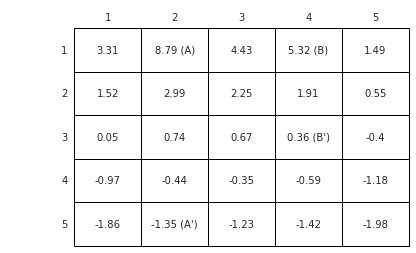

In [14]:
%%time
vf = gw.value_iteration(action_probability=0.25, discount=0.9)
gw.draw(np.round(vf.reshape(gw.grid_size, gw.grid_size), decimals=2))

CPU times: user 20.4 ms, sys: 303 µs, total: 20.7 ms

Wall time: 21.4 ms


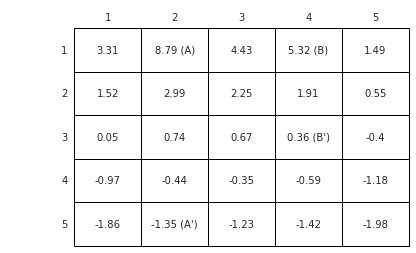

In [15]:
%%time
vf = gw.value_function(action_probability=0.25, discount=0.9)
gw.draw(np.round(vf.reshape(gw.grid_size, gw.grid_size), decimals=2))

**d**) Repeat b) and c) for $\gamma = 0.3$.

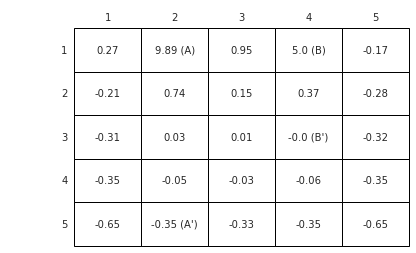

In [17]:
vf = gw.value_function(action_probability=0.25, discount=0.3)
gw.draw(np.round(vf.reshape(gw.grid_size, gw.grid_size), decimals=2))

**f**) Finally, let's find the optimal policy and value functions to navigate the grid world

In [20]:
def optimal_value_function(grid_size, action_space, discount):
    value = np.zeros((grid_size, grid_size))
    while True:
        # keep iteration until convergence
        new_value = np.zeros_like(value)
        for i in range(grid_size):
            for j in range(grid_size):
                values = []
                for action in action_space:
                    (next_i, next_j), reward = step([i, j], action)
                    # value iteration
                    values.append(reward + discount * value[next_i, next_j])
                new_value[i, j] = np.max(values) 
        if np.sum(np.abs(new_value - value)) < 1e-4:
            return new_value
        else:
            value = new_value

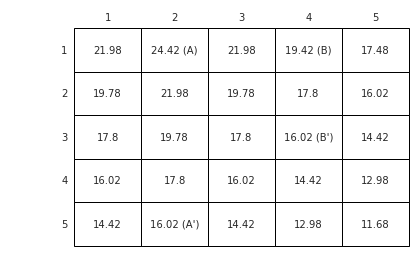

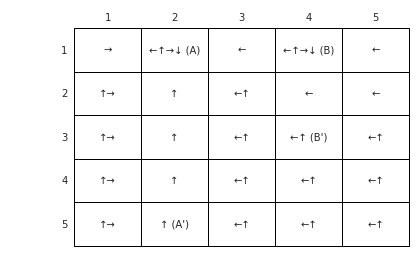

In [21]:
gw = GridWorld(grid_size, A_pos, A_prime_pos, B_pos, B_prime_pos, ACTIONS, ACTIONS_REP)
ovf = gw.optimal_value_function(discount=0.9)
gw.draw(np.round(ovf.reshape(gw.grid_size, gw.grid_size), decimals=2))
op = gw.draw_policy(ovf)